## Практическое задание к курсу

<ol>
    <li>Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.</li>
    <li>Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике? 
    </li>


</ol>

* first attempts were devoted to the use of the segmentation model from lesson 6 on a new dataset: flic (dataset of images with bounding box segmentation of human torsoes).
But eventualy it became apparent that the given model is classification oriented and can not be used for BBox coordinates prediction
* so we'll try Oxford IIIT pet dataset

## Image segmentation with bounding box

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
import tensorflow_datasets as С
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

## Dataset loading

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to C:\Users\Армик\tensorflow_datasets\oxford_iiit_pet\3.2.0. Subsequent calls will reuse this data.


In [25]:
#exploring info content
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\Армик\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling

In [8]:
dataset

{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [9]:
# dataset is already split to two PrefetchDataset objects train and test. We'll check the number of elements
print(len(dataset['train']), len(dataset['test']))

3680 3669


In [27]:
info.splits['train'].num_examples

3680

In [10]:
#saving separately train and test datasets
ds_train = dataset['train']
ds_test = dataset['test']

In [17]:
# exploring images and masks
images = [elemnt['image'] for elemnt in ds_train]
masks = [elemnt['segmentation_mask'] for elemnt in ds_train]
print(tf.math.reduce_min(images[0]), tf.math.reduce_max(images[0]))
print(tf.math.reduce_min(masks[0]), tf.math.reduce_max(masks[0]))

In [4]:
# to normalize data we'll divide image values to max value (255) and mask values make from value 0 to 2 instead of 1 to 3
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [5]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [6]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [29]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [31]:
train = ds_train.map(load_image_train)
test = ds_test.map(load_image_test)

In [32]:
train_dataset = ds_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = ds_test.batch(BATCH_SIZE)

Давайте посмотрим на пример  изображения из датасета и соотвествующую ему маску из датасета.

In [33]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

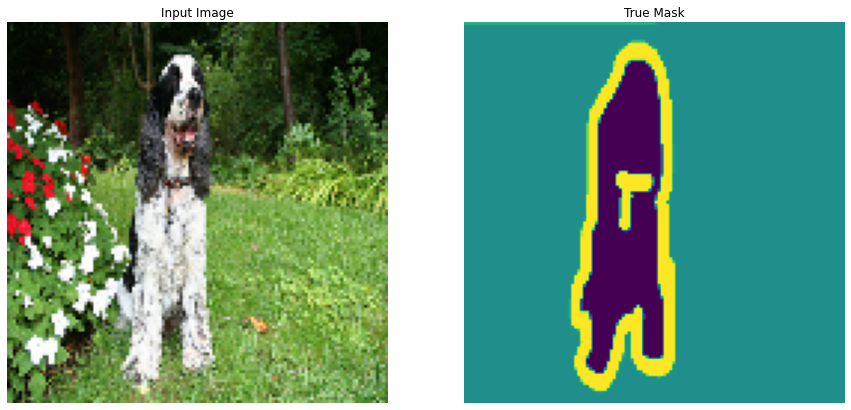

In [36]:
for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Определение модели

Будем использовать модифицированный U-Net. В качестве энкодера будет использоваться предтренированный MobileNetV2.
Декодером будет апсемпл блок уже имплементированный в TensorFlow examples [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py).

Причина по который будет испольваться три канала заключается в том что у нас 3 возможных лейбла на каждый пиксель. Можно это воспринимать как классиификацию где кажедый пиксель будет принадлежать одному из трех классов.

In [ ]:
OUTPUT_CHANNELS = 3

Как упоминалось ранее энкодером будет предтренированный MobileNetV2, который подготовлен и готов к использованию - [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). Энкодер состоит из определенных аутпутов из средних слоев модели. Обратите внимание энкодр не будет участвовать в процессе тренировкие модели.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
layers



Декодер/апсемплер это просто серия апсемпл блоков имплементированнхы в TensorFlow examples.

In [ ]:
pix2pix.upsample?

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Тренировка модели
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

Теперь, все что осталось это скомпилировать модель и начать процесс ее тренировки. Loss-функция, которую будем использовать - `losses.SparseCategoricalCrossentropy(from_logits=True)`. Причина использования данной loss-функции заключается в том, что нейросеть пытается назначить каждому пикселю лейбл, также как в задачах предсказания класса. Для модели в которой 3 каннала каждый из которых пытается предсказать класс `losses.SparseCategoricalCrossentropy(from_logits=True)` обычно также рекомендуется.
На выходе нейросети каждому пикселю назначается лейбл с наибольшим значением. Это то, что делает функция create_mask.


In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='SGD',
              loss=tf.keras.losses.KLDivergence(),
              metrics=['top_k_categorical_accuracy'])

Посмотрим на получившуюся архитектуру модели.

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


Давайте попробуем сделать предсказание с помощью нашей модели до того как началось обучение.

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions()



Давайте осуществлять мониторинг того как улучшается работа модели в процессе обучения. Для завершения этой задачи callback функция определена ниже.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Давайте сделаем несколько предсказаний. Для экономии времени использовалось небольшое количество эпох, но вы можете его увеличить для того чтобы модель давала более точные результаты.

In [ ]:
show_predictions(test_dataset, 3)

## Практическое задание

<ol>
    <li>Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
        Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?
    </li>
    <li>*Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview</li>
    <li>*Сделайте свою реализацию U-Net на TensorFlow</li>
</ol>

## Дополнительные материалы

<ol>
    <li>Оригинальная научная статья по FCN - https://arxiv.org/pdf/1411.4038.pdf</li>
    <li>Оригинальная научная статья по SegNet - https://arxiv.org/pdf/1511.00561.pdf</li>
    <li>Оригинальная научная статья по U-Net - https://arxiv.org/pdf/1505.04597.pdf</li>
     <li>Оригинальная научная статья по FPN - https://arxiv.org/pdf/1612.03144.pdf</li>
     <li>Оригинальная научная статья по Mask R-CNN - https://arxiv.org/pdf/2001.05566.pdf</li>
     <li> Научная статья с обзором отрасли сегментации изображений с помощью глубокого обучения - https://arxiv.org/pdf/2001.05566.pdf</li>
</ol>

## Используемая литература 

Для подготовки данного методического пособия были использованы следующие ресурсы:
<ol>
    <li>https://www.tensorflow.org/tutorials/images/segmentation</li>
    <li>Image Segmentation Using Deep Learning: A Survey. Shervin Minaee и др. 15 Jan 2020</li>
    <li>Mask R-CNN, Kaiming He и др. 24 янв. 2018 г.</li>
    <li>https://blog.athelas.com/a-brief-history-of-cnns-in-image-segmentation-from-r-cnn-to-mask-r-cnn-34ea83205de4</li>
    <li>Википедия</li>  
</ol>